https://www.notion.so/zshan0notes/Task-2-Report-51e7f9db08664545a5b9f6bb5274cf30

# QOSF Task 2 $\rightarrow$ Constructing a classifier

## Problem statement
To train a quantum variational circuit that will serve as a 4 bit map.

In [1]:
try:
    import pennylane as qml
    from pennylane import numpy as np
    from pennylane.optimize import NesterovMomentumOptimizer
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-whitegrid')
except:
    !pip install pennylane  
    import pennylane as qml
    from pennylane import numpy as np
    from pennylane.optimize import NesterovMomentumOptimizer
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-whitegrid')

     |████████████████████████████████| 631 kB 37.0 MB/s 
     |████████████████████████████████| 4.4 MB 36.5 MB/s 


$$
map(\text{input_state}[i]) = \text{output_state}[i]
$$

## Setting random quantum states
$$
|0000\rangle \rightarrow |0011\rangle \\
|0001\rangle \rightarrow |0101\rangle \\
|0010\rangle \rightarrow |1010\rangle \\
|0011\rangle \rightarrow |1100\rangle \\
$$

In [2]:
input_states = np.array([[0, 0, 0, 0],[0, 0, 0, 1],[0, 0, 1, 0], [0, 0, 1, 1]])
output_states = np.array([[0, 0, 1, 1],[0, 1, 0, 1],[1, 0, 1, 0], [1, 1, 0, 0]])

For making the classification more distinct will transform the target bits into:
$$
    0 \rightarrow -1\\
    1 \rightarrow 1
$$

In [3]:
def Y_transform(y):
    return 2 * y - 1

In [4]:
dev = qml.device("default.qubit", wires=4)

Setting 3 layers of gates with a rotation followed by CNOTS and another layer of rotation

In [5]:
def layer(W):
    # each rotation matrix takes in 3 inputs (phi, theta, omega)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])
    
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

In [6]:
def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

## Circuit
The circuit at the end will have to do a measurement to convert the states into classical bits so that the loss can be calculated

we apply `PauliZ` on all the qubits and then return the expected value on the observable.

In [7]:
def circuit(weights, x):
    statepreparation(x)

    # weights is a matrix
    for W in weights:
        layer(W)


In [8]:
@qml.qnode(dev)
def variational_classifier(var, x):
    weights = var
    circuit(weights, x) 
    return [qml.expval(qml.PauliZ(x)) for x in range(4)] # because 1 and -1 

## Loss
Mean Squared Error between the expected and the output is set to be the loss

## Accuracy
Accuracy is the number of correct predictions with a small margin of error

## Cost
The cost is just MSE over all(4) predictions and targets

In [9]:
def square_loss(labels, predictions):
    return np.mean(np.array([np.sum((l - p) ** 2) for l, p in zip(labels, predictions)]))

In [10]:
def accuracy(labels, predictions, err = 1e-5):
    return np.mean(np.array([int(abs(np.sum(l - p)) < err) for l, p in zip(labels, predictions)]))

In [11]:
def cost(var, X, Y):
    return square_loss(Y, [variational_classifier(var, x) for x in X])

In [12]:
X = input_states
Y = Y_transform(output_states)

Setting the learning rate low since the values are sensitive

In [13]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 4 # Since there are only 4 samples

The initiale values of the weights are set to be small random values

In [14]:
np.random.seed(0)
num_qubits = 4
num_layers = 3
var_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)

### Training

In [15]:
var = var_init

for it in range(200):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    var = opt.step(lambda v: cost(v, X_batch, Y_batch), var)

    predictions = [np.sign(variational_classifier(var, x)) for x in X]
    acc = accuracy(Y, predictions)
    cost_val = cost(var, X, Y)
    
    if cost_val < 0.6:
        break
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost_val, acc
        )
    )

Iter:     1 | Cost: 7.9884350 | Accuracy: 0.7500000 
Iter:     2 | Cost: 7.9792539 | Accuracy: 0.7500000 
Iter:     3 | Cost: 7.9559459 | Accuracy: 0.7500000 
Iter:     4 | Cost: 7.8982185 | Accuracy: 0.7500000 
Iter:     5 | Cost: 7.7575614 | Accuracy: 0.7500000 
Iter:     6 | Cost: 7.4302649 | Accuracy: 0.7500000 
Iter:     7 | Cost: 6.7731560 | Accuracy: 0.7500000 
Iter:     8 | Cost: 5.7770169 | Accuracy: 0.7500000 
Iter:     9 | Cost: 4.7829131 | Accuracy: 0.7500000 
Iter:    10 | Cost: 4.1742929 | Accuracy: 0.7500000 
Iter:    11 | Cost: 3.9411120 | Accuracy: 0.5000000 
Iter:    12 | Cost: 3.8857454 | Accuracy: 0.2500000 
Iter:    13 | Cost: 3.8568668 | Accuracy: 0.2500000 
Iter:    14 | Cost: 3.7954571 | Accuracy: 0.0000000 
Iter:    15 | Cost: 3.6449191 | Accuracy: 0.0000000 
Iter:    16 | Cost: 3.4141273 | Accuracy: 0.2500000 
Iter:    17 | Cost: 3.1490518 | Accuracy: 0.2500000 
Iter:    18 | Cost: 2.9294497 | Accuracy: 0.5000000 
Iter:    19 | Cost: 2.8387169 | Accuracy: 0.50

In [16]:
def to_bit(x):
    l = list("{0:b}".format(x))
    l = [int(x) for x in l]
    while len(l) != 4:
        l.insert(0, 0)
    return l

In [17]:
def to_num(x):
    x = x[::-1]
    return sum([(x[i] * (2**i)) for i in range(len(x))])

In [18]:
def predict(x):
    ''' Assuming that the input is np.array of 4 bits(0 or 1)'''
    y = np.sign(variational_classifier(var, x))
    y = np.array([int(l == 1) for l in y]) # converting it back to bits
    return y

In [19]:
x = list(range(16))
y = []
for i in x:
    j = predict(to_bit(i))
    j = j.numpy()
    y.append(to_num(j))

x_actual = [to_num(i) for i in input_states]
y_actual = [to_num(i) for i in output_states]

labels = ['|' + ''.join([str(l)  for l in to_bit(i)]) + '>' for i in x]

## Plotting the classifier output

We convert the bits into integer based on big endian conversion. This will allow us to plot the expected answer and the prediction for the values that haven't been trained.

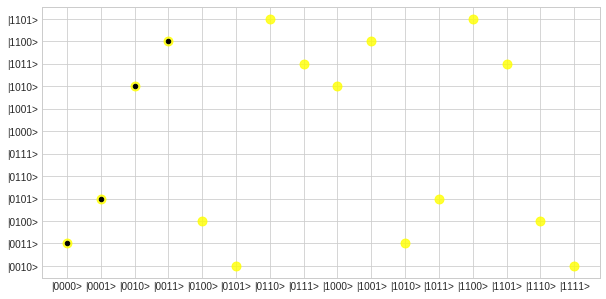

In [20]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_yticks(x)
ax.set_yticklabels(labels)
plt.scatter(x, y, color='yellow', alpha=0.8, s=80)
plt.scatter(x_actual, y_actual, color='black', alpha=1, s=20)